In [ ]:
! pip install weightwatcher  transformers 

## Makes plots for theory paper: Effective Correlation Space

### This is the simplest possible modern MLP, 3 layers trained on MNIST

**IMPORTANT**:
- First train the models. See WW_MLP3_Training_pytorch.ipynb or WW_MLP3_Training_keras.ipynb
- Secondly the `main()` function in `shuffled_accuracy.py` needs to be called and run to completion for this notebook to be able to plot results.


In [ ]:
# If you are running this NB in google colab then execute this cell

from google.colab import drive
drive.mount('/drive')
results_dir = '/drive/MyDrive/setol_paper'

!ls $results_dir

In [1]:
import os
os.chdir("../pytorch")

from models import MLP3
from trainer import Trainer, PreLoader
from pildataset import PILDataSet
from plot_utils import plot_truncated_accuracy_over_epochs

# If you are running this NB locally then set your results directory and execute this cell

results_dir = "../pytorch/saved_models/SETOL"
!ls $results_dir

MNIST  OLD_FASHION  OLD_MNIST  TEST


## Effective Correlation Space: Truncated SVD

The Heavy Tailed Self Regularization (HTSR) theory and Semi-Empirical Theory of Learning (SETOL) posit that the model's predictions - and hence its ability to generalize - are concentrated in the larger eigenvalues of each weight matrix, i.e. the tail of the ESD. In particular, the HTSR theory says that above a certain $\lambda_\mbox{PL}$, (referred to as `xmin` in the WeightWatcher code,) the eigenvalues of $\mathbf{W}^T\mathbf{W}$ follow a power law with exponent $\alpha$, whereas the SETOL posits that above a certain $\lambda_\mbox{detX}$ the product of eigenvalues is $1$. When Ideal Learning has taken place, the subspace that produces the model's predictions is called an **Effective Correlation Space**. The complement of this space is called the **bulk**, and (when Ideal Learning has taken place,) is effectively random.

In both of these cases we would expect that, in a well-trained model, if we perturb the bulk, i.e. the eigenvalues less than $\lambda_\mbox{PL}$ or $\lambda_\mbox{detX}$, the model's predictions would be largely unchanged. The simplest way to perturb these spaces is to drop all eigenvalues less than $\lambda_\mbox{PL}$ pr $\lambda_\mbox{detX}$, and that is what we will do. This process replaces each weight matrix with a low rank approximate consisting of *only* the tail.

The code below makes plots for each learning rate or batch size. (To see the results for the batch size experiment, change the `search_param` variable to `BS`). In each plot, there are two lines - one <font color="orange">orange</font> and one <font color="blue">blue</font>. The <font color="orange">orange</font> line shows the difference in **test** accuracy between the perturbed, and the unperturbed model, with error bars showing $1$ st. dev., for each epoch. The error bars are computed over $5$ runs with different random seeds. Likewise, the <font color="blue">blue</font> line shows the difference in **train** accuracy between the perturbed and unperturbed models. The second plot shows the difference in **loss** function. For reference, we will also show the $\alpha$ value for each trained layer.

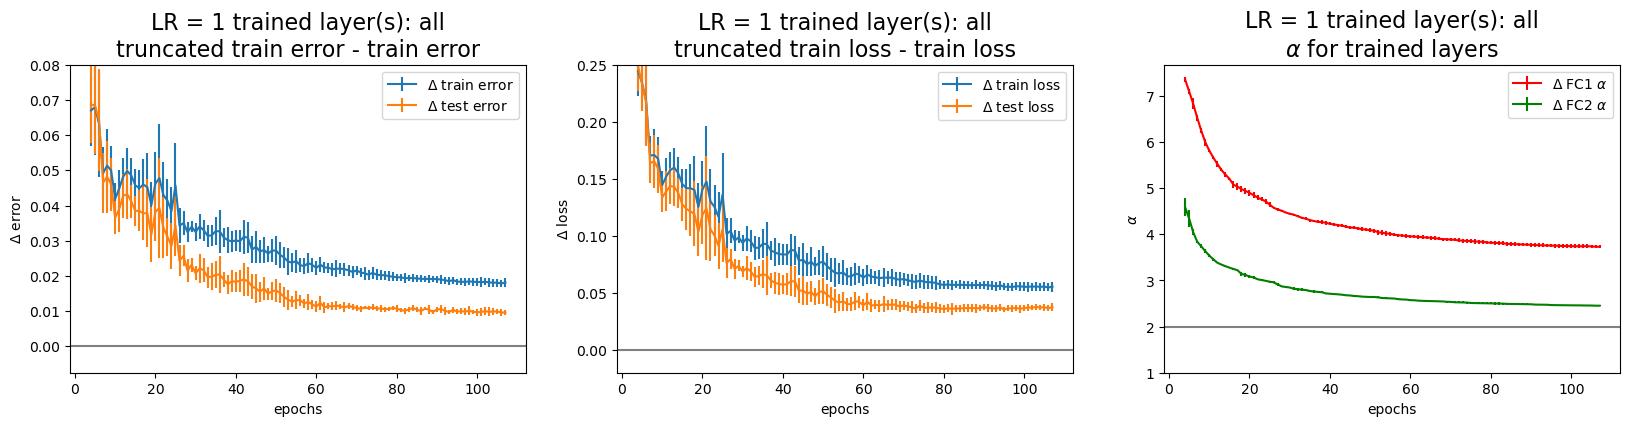

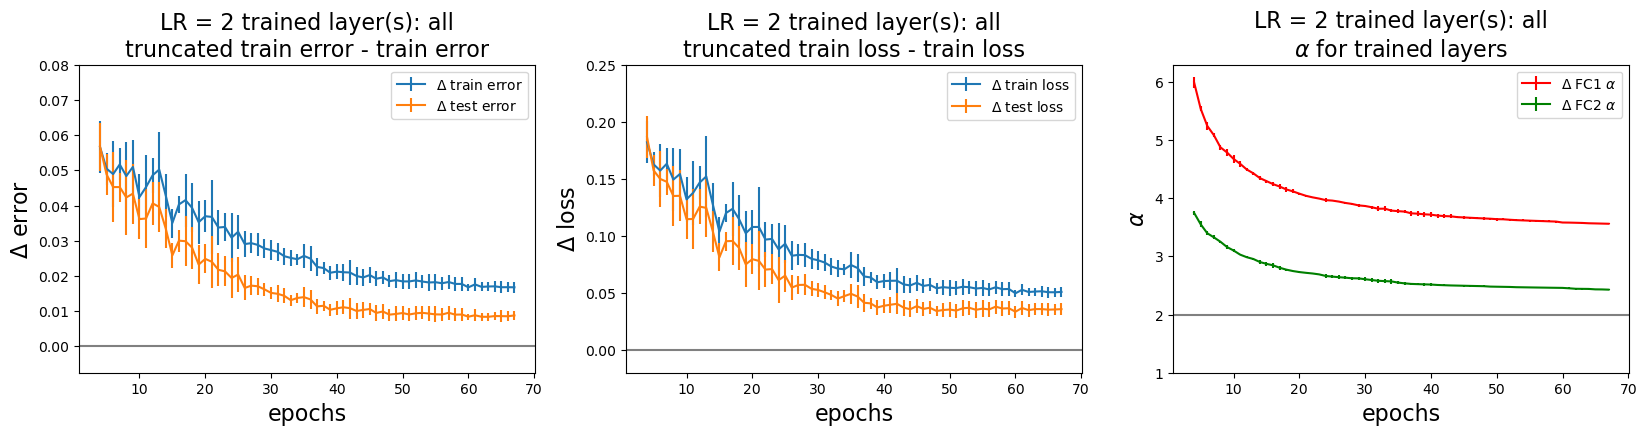

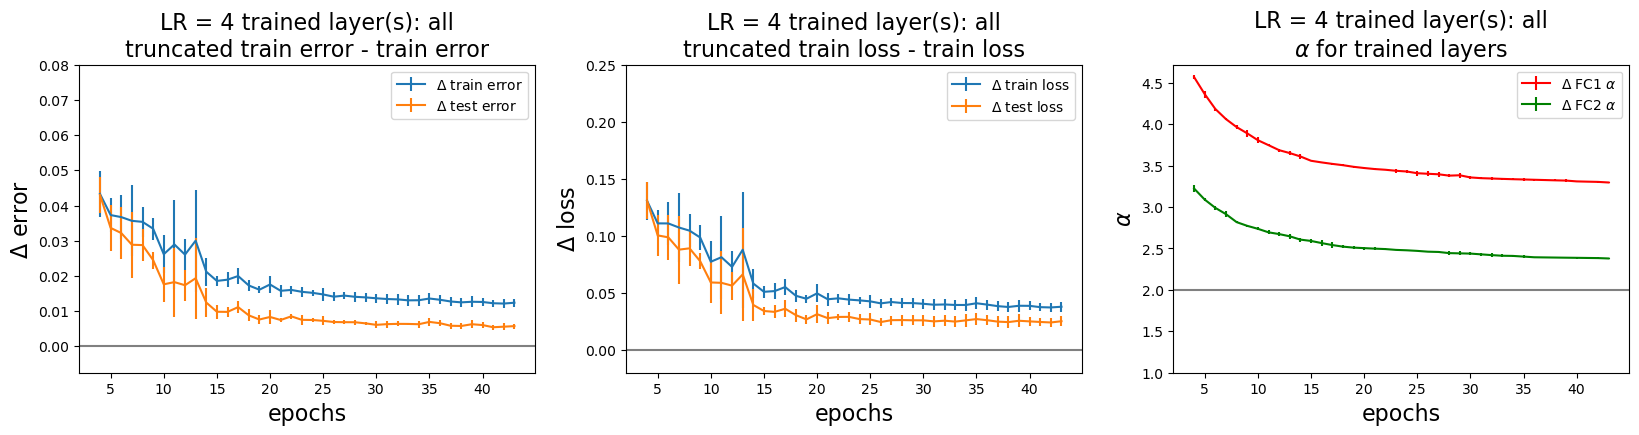

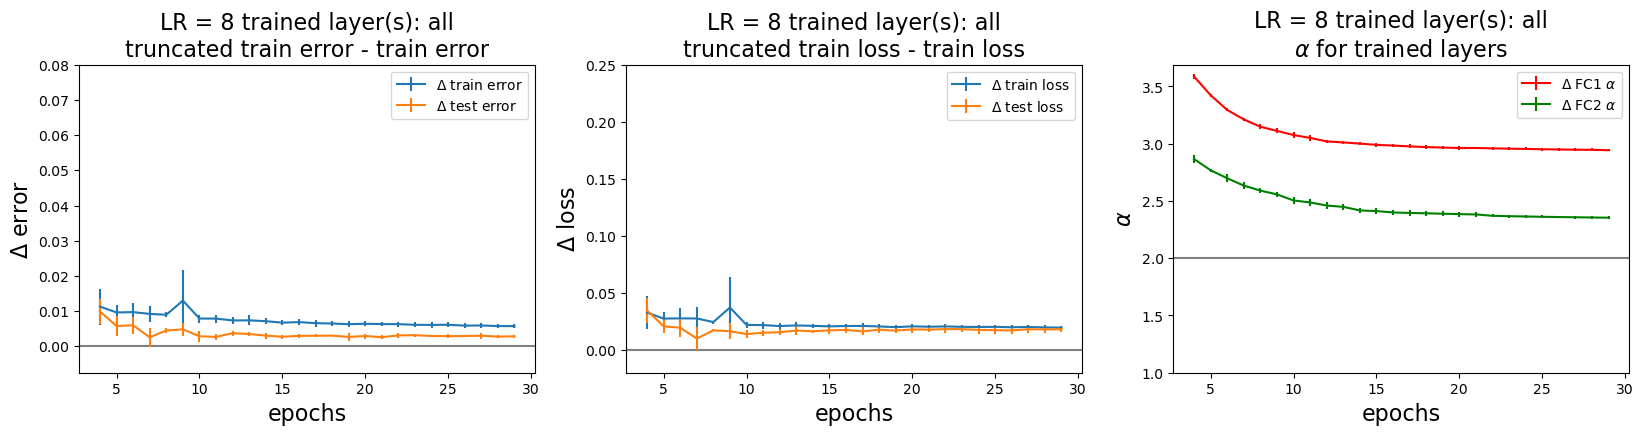

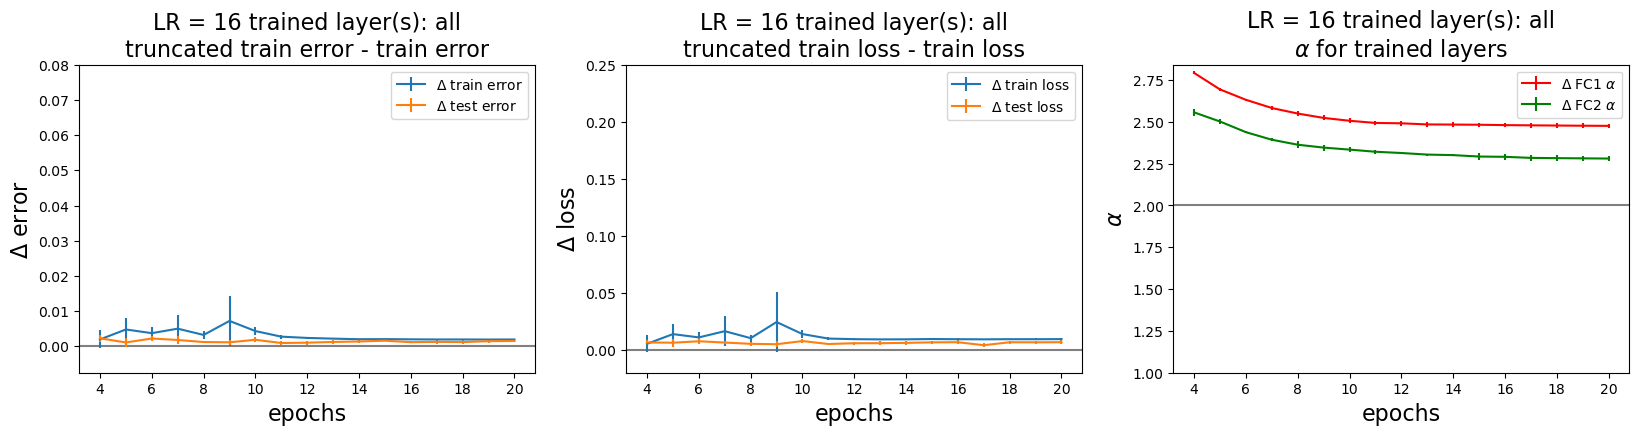

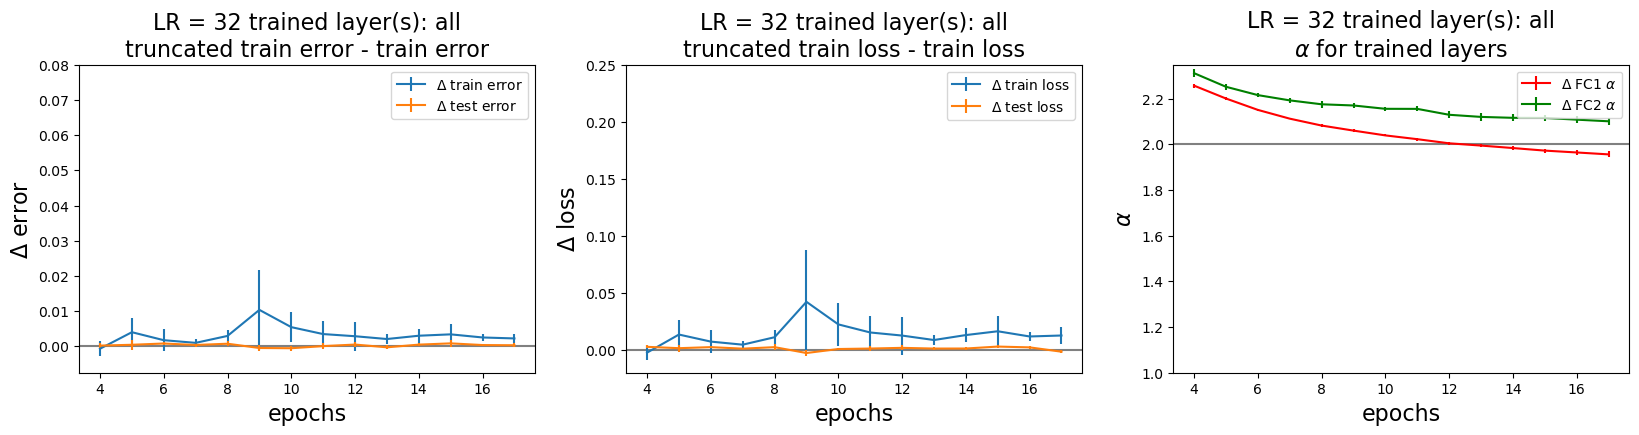

In [2]:
from plot_utils import plot_truncated_accuracy_over_epochs

DS = "MNIST"
search_param = "LR"

for scale in range(6):
  plot_truncated_accuracy_over_epochs(DS, "all", search_param, scale, range(5), ylims=(0.08, 0.25), XMIN=True, save_dir="figs/truncated_error")

### Several things are apparent from these plots.

First, the <font color="blue">blue</font> line is always above the <font color="orange">orange</font> line, (except in some of the early epochs where the tail has not yet formed). This means that when we perturb the weight matrices by dropping the bulk, the training error is impacted more than the test error. Since the bulk contains components that are effectively random, (according to both theories,) the fact that the training error is impacted more means that the model is using some of its randomness to generate correct classifications - overfitting by definition. Yet, the test predictions are less affected by this perturbation, meaning that the test cases are less affected by the bulk, meaning that the tail really does identify a subspace that generalizes better, just as both theories predict.

We can also see that as training progresses, both lines get closer to $0$, up to an asymptotic limit that depends on the overall Learning Rate, (or equivalently on the Batch Size). This means that as a side effect of learning, by reducing the training error, the model also discovers a subspace that generalizes better. It also means that larger Learning Rates, (or smaller Batch Sizes,) act as a kind of regularization - they don't necessarily make the model more accurate, but they do a better job of concentrating the models predictions into the tail, in a way that generalizes better. 

Looking closely, we can also see that there are transitions where the perturbed error gap suddenly decreases, which is often preceded immediately by an abnormally large error bar. This is similar in some ways to what happens in a First Order Phase Transition in Statistical Mechanics.

The $\alpha$ metrics behave largely as we would expect, though notice that at the largest Learning Rate of $32\times$ normal, the $\alpha$ metrics are inverted: $\alpha_\mbox{FC1}$ decreases below $\alpha_\mbox{FC2}$, and also passes beneath the critical value of $2.0$.

Next, we will consider the other criterion - using $\lambda_\mbox{detX}$ to set the boundary of the tail vs. the bulk, rather than $\lambda_\mbox{PL}$. This new correlation space is found by demarcating a boundary $\lambda_\mbox{detX}$ such that the product of all eigenvalues above it is approximately $1$. This will have one distinct difference from $\lambda_\mbox{PL}$: As the power-law tail starts small, and grows larger over trainining, we saw that the gap starts out large and gets smaller. In contrast, this Effective Correlation space starts out *too large* and *grows smaller* over the course of training. This means that it should have an opposite shape as the other curve, but over the course of training we expect the two correlation spaces to converge to one another.

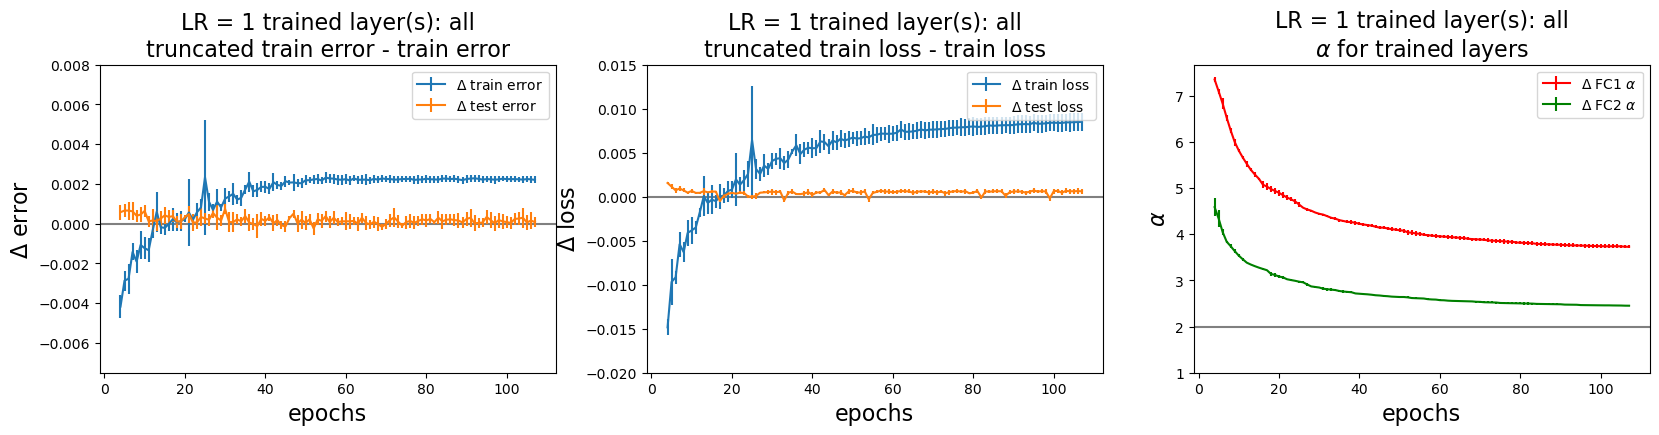

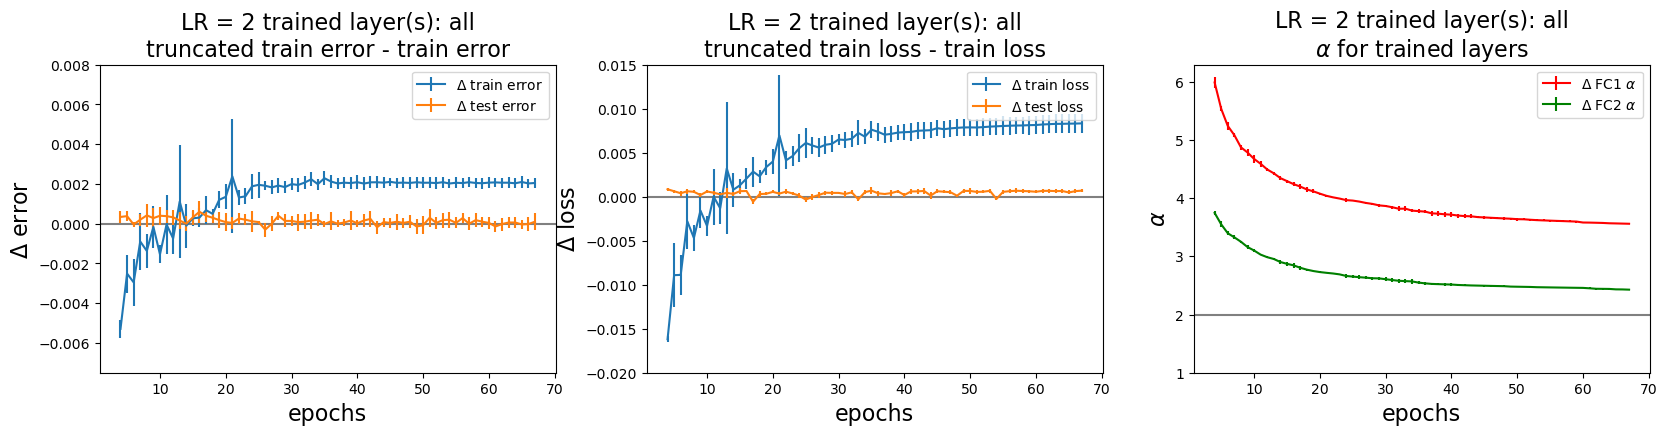

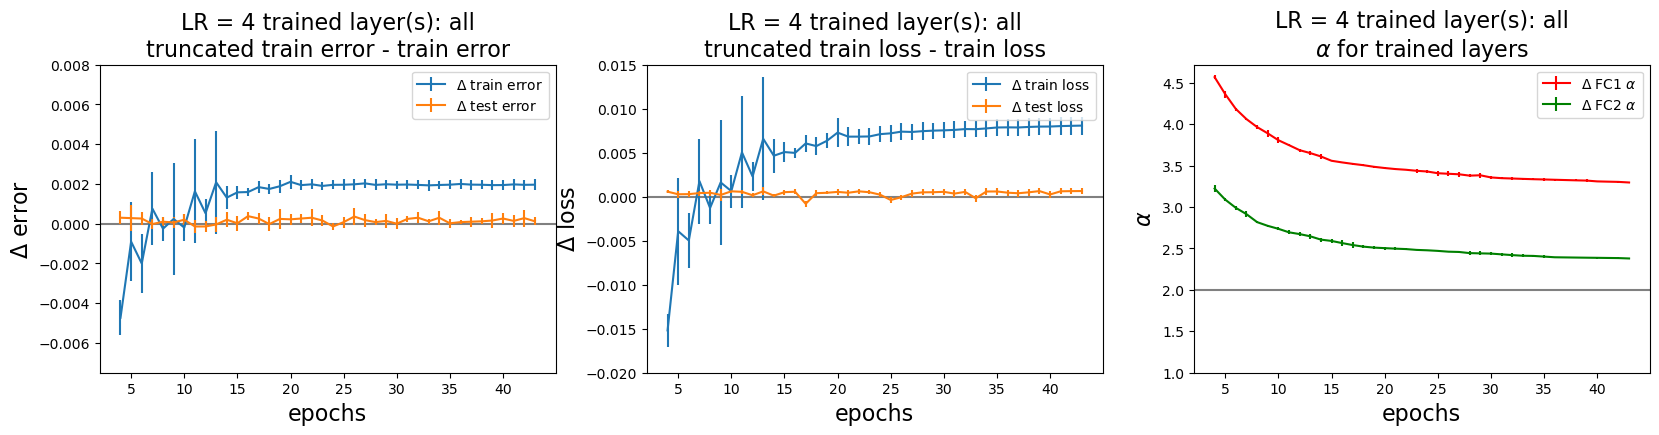

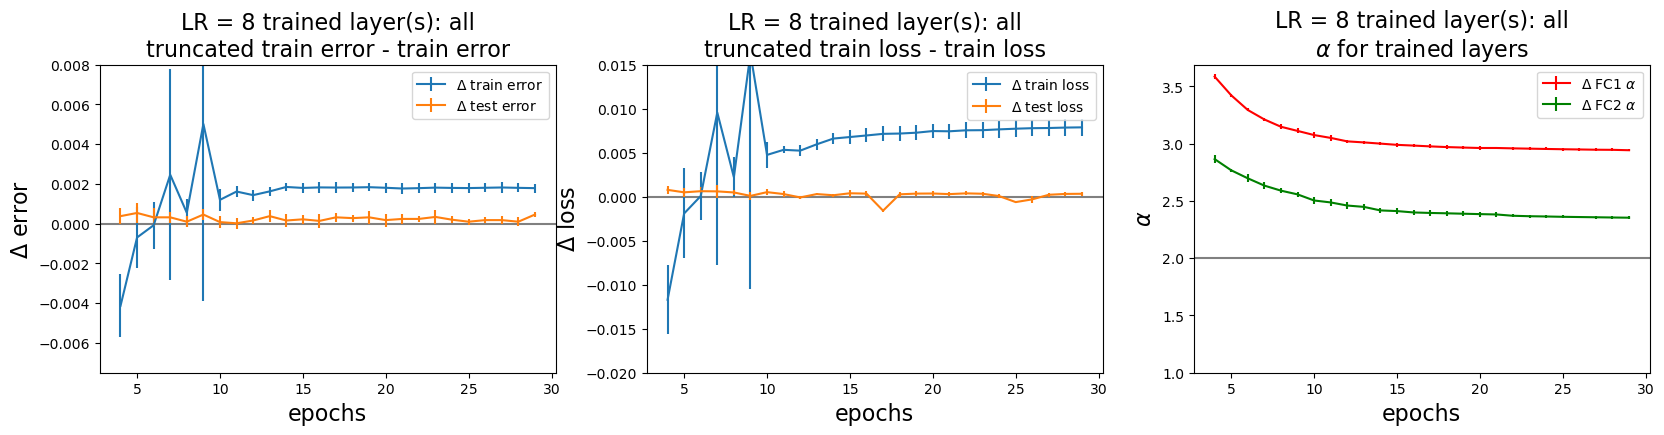

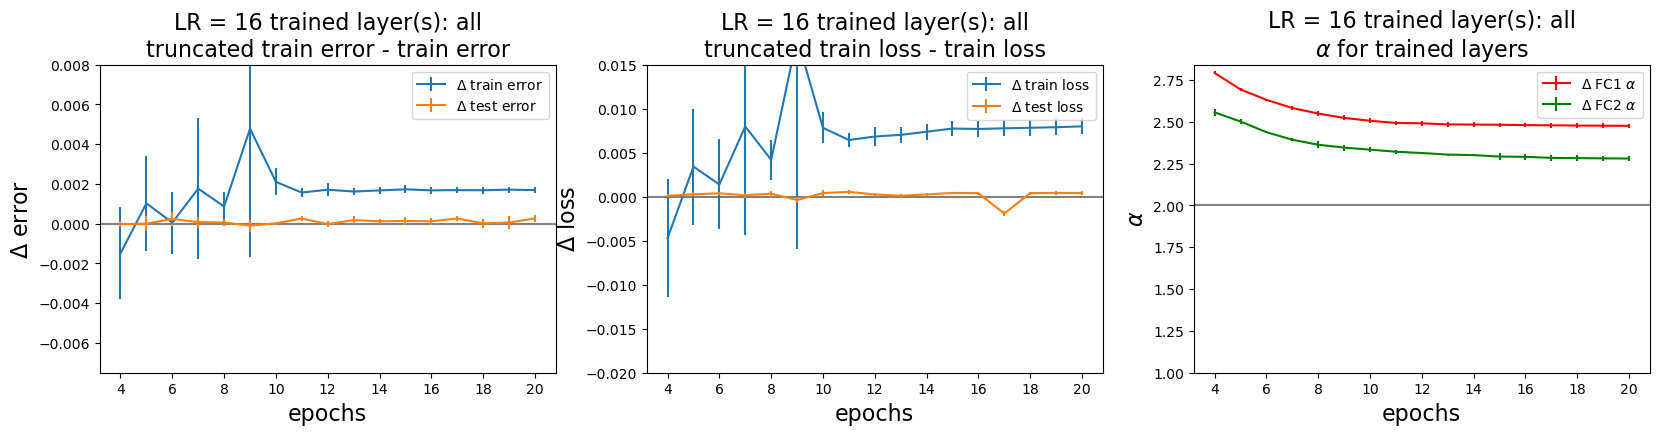

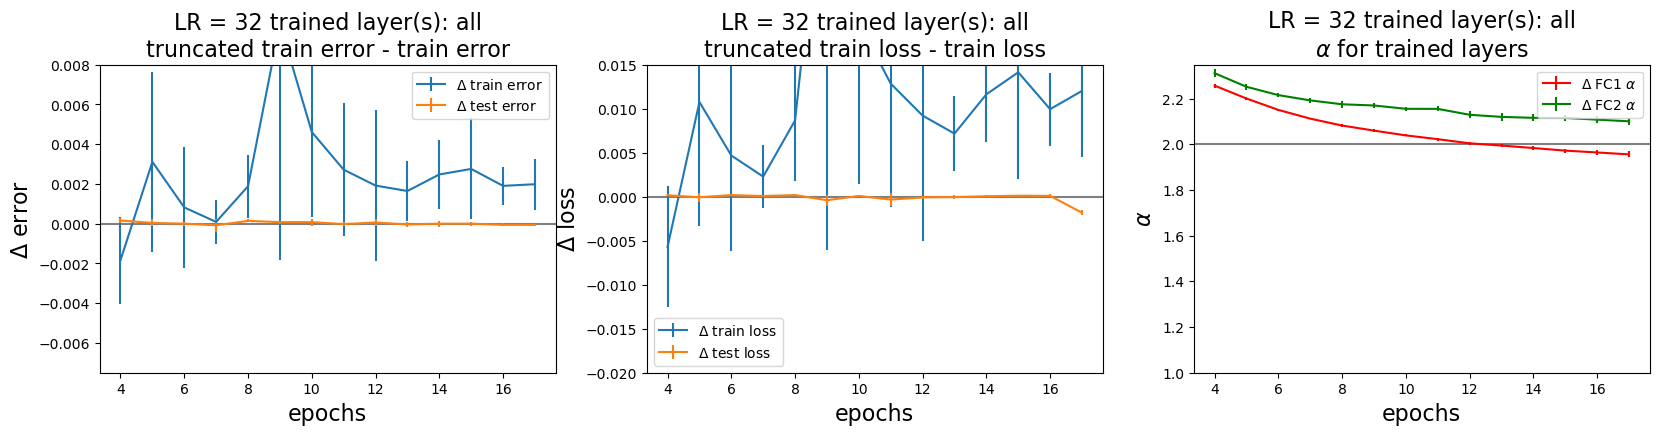

In [3]:
from plot_utils import plot_truncated_accuracy_over_epochs

DS = "MNIST"
search_param = "LR"

for scale in range(6):
  plot_truncated_accuracy_over_epochs(DS, "all", search_param, scale, range(5), ylims=(0.008, 0.015), XMIN=False, save_dir="figs/truncated_error")

### Again we see that the blue curve stays above the orange one

We also see that the higher the Learning Rate (equivalently, the lower the Batch Size,) the smaller the gap between test error and truncated test error. And, as expected, early in training, truncating the bulk has the opposite effect as before, because we are truncating *too much* rather than *too little*. Moreover, early in training, sometimes the gap can be *negative*. Why? because early in training the model is far from equilibrium, and the weight matrices are mostly random. Simply deleting this randomness means that the generalizing components that are beginning to form in the tail are better exposed, and are better able to perform. This effect is short-lived, however, as the tail eventually dominates the bulk on its own. It should also be pointed out that the scale of the y axis is $\mathbf{10\times}$ **less**. Again, this is because $\lambda_\mbox{detX}$ converges from below, meaning that it under-estimates the bulk, meaning that its truncation effect will be substantially less.

For most of the learning rates considered, we can also see the same phase-transition-like effect, wherein suddenly the error bars become narrower, but only after an epoch where they are spiked.

Next we consider what happens when we train *only one layer*. FC1 is the $300$ unit layer, closest to the data. Here again we use the `xmin` criterion to choose a Power-law based tail, whose complement will be truncated.

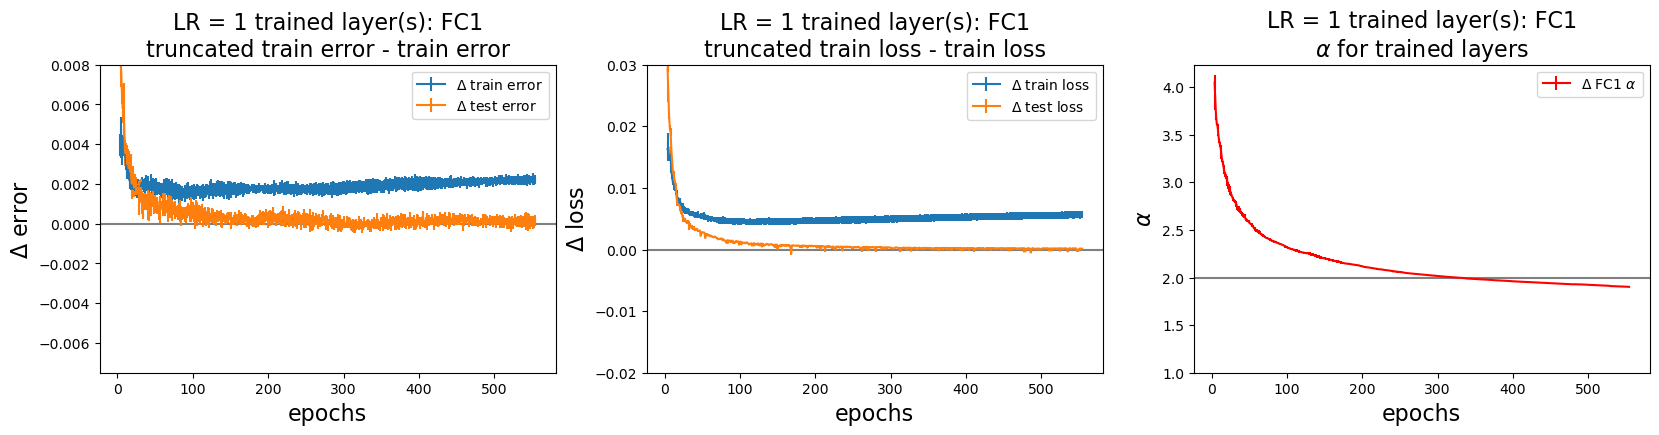

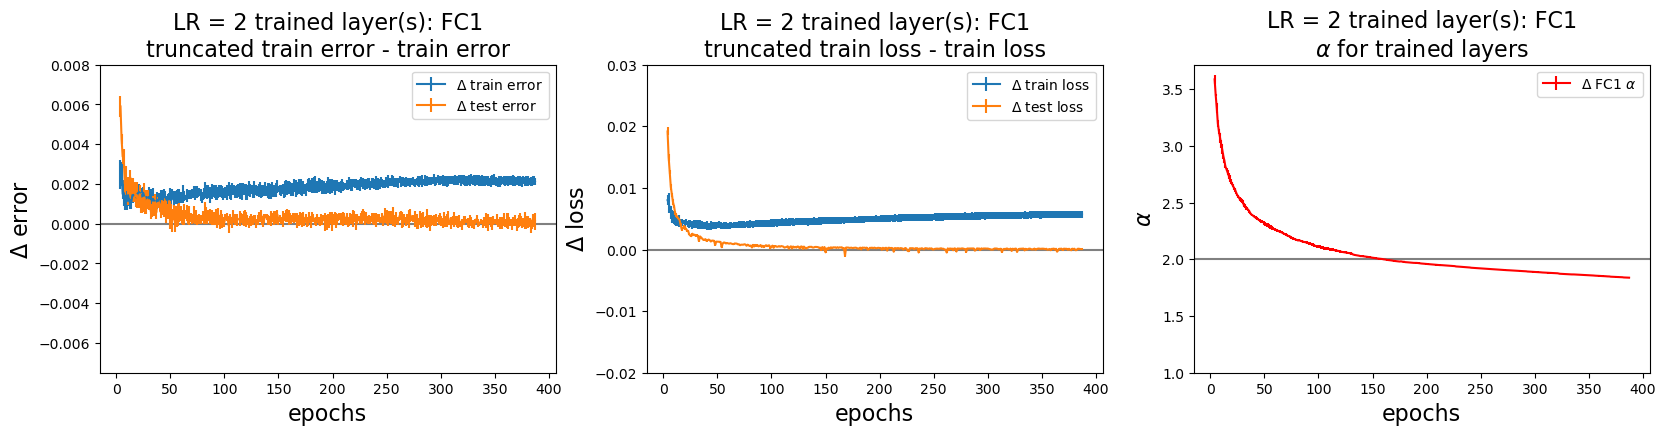

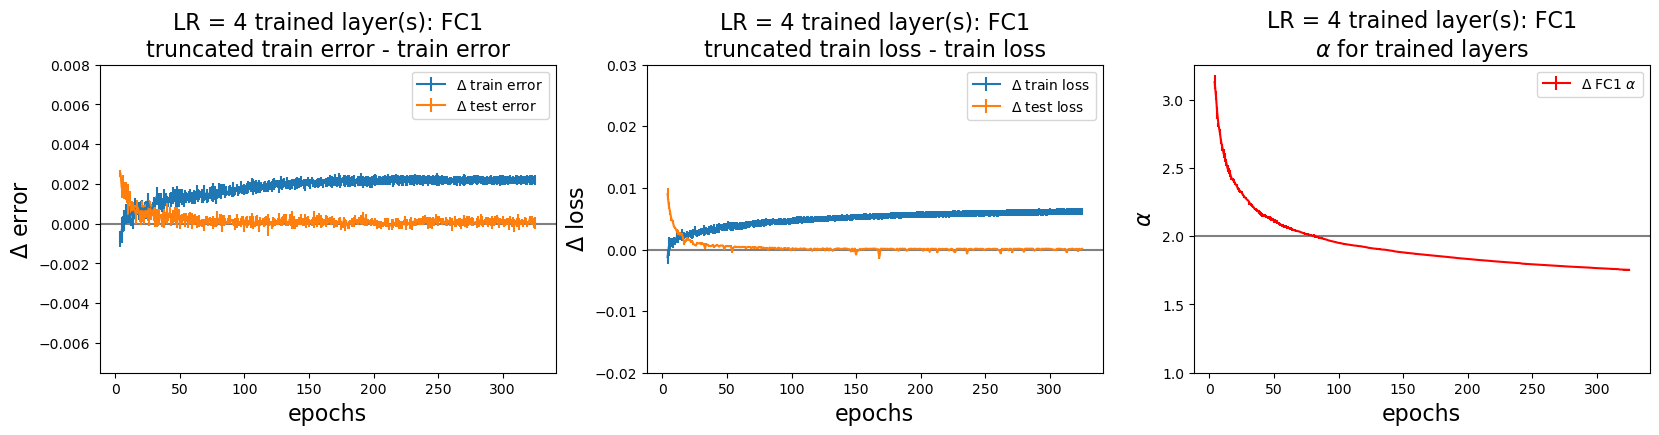

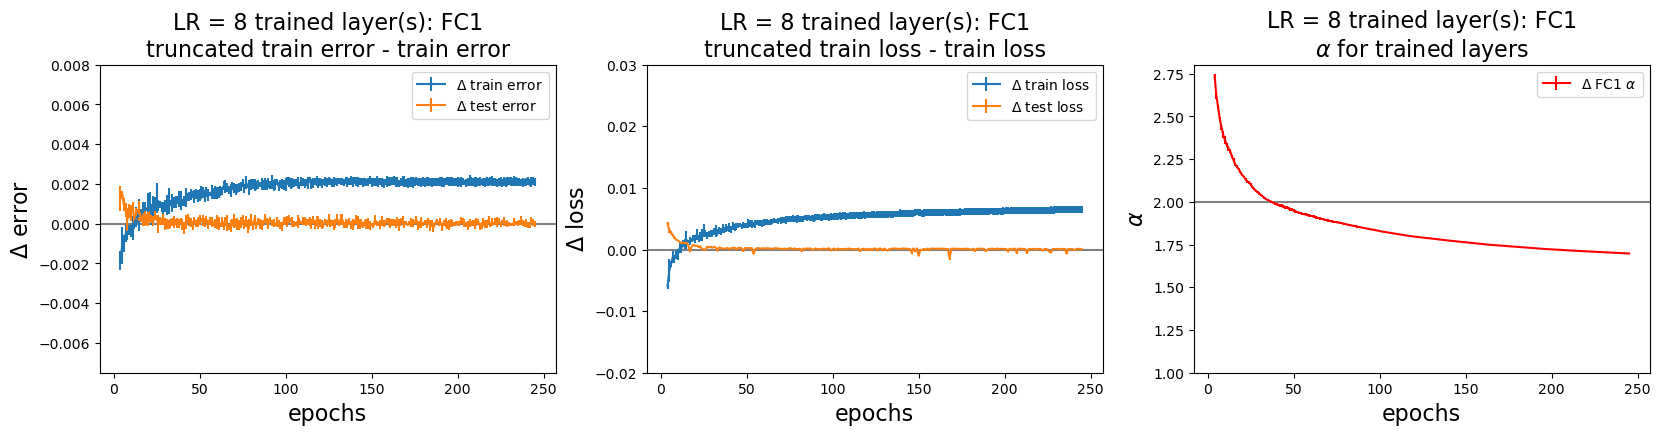

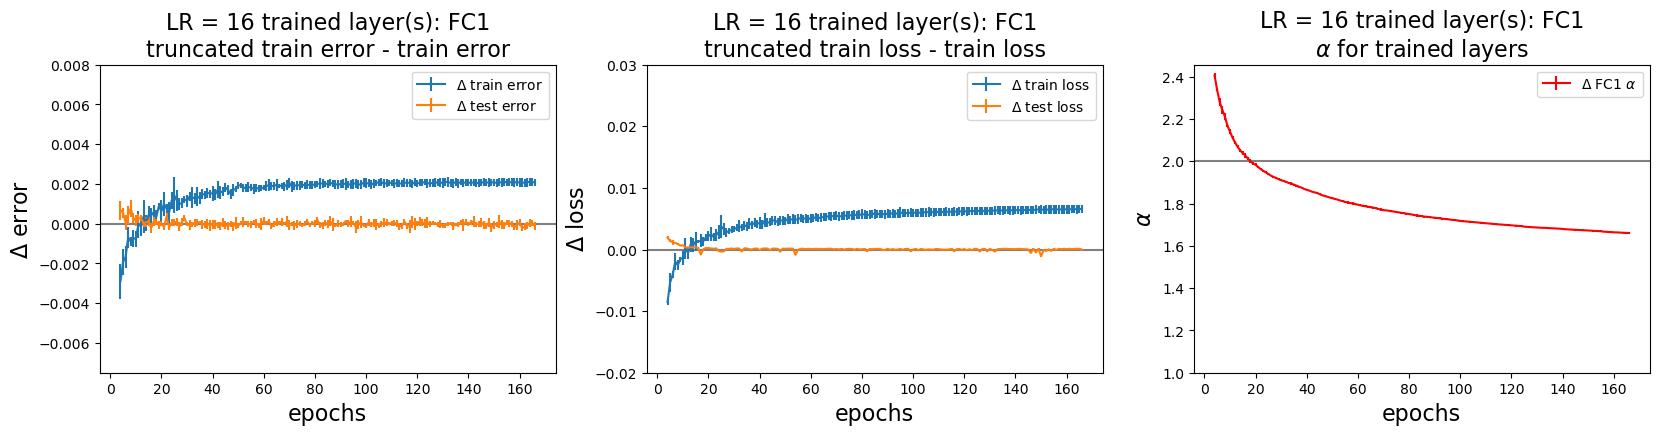

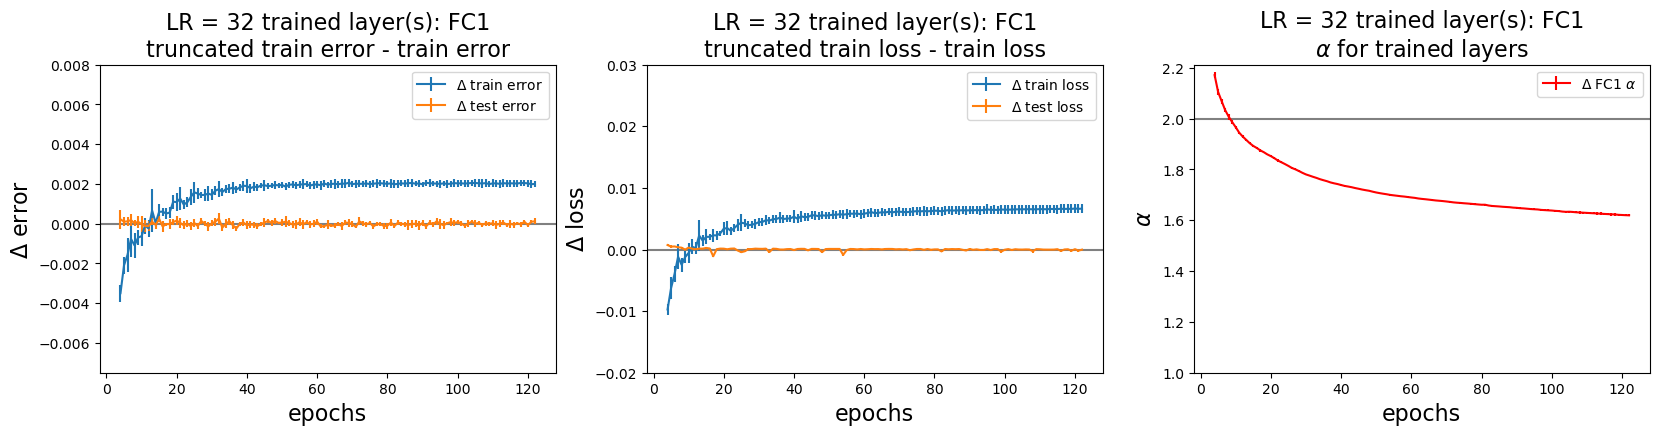

In [4]:
from plot_utils import plot_truncated_accuracy_over_epochs

DS = "MNIST"
search_param = "LR"

for scale in range(6):
  plot_truncated_accuracy_over_epochs(DS, "FC1", search_param, scale, range(5), ylims=(0.008, 0.03), XMIN=True, save_dir="figs/truncated_error")

### Here again we see some of the same patterns as before, and some different.

Here again, the <font color="blue">blue</font> line is always above the <font color="orange">orange</font> line, except that now in early epochs it's consistently lower. Why would that be? If the training gap is negative, that means that we have *misidentified* the Effective Correlation Space. We identify it fitting a power law to the largest eigenvalues, and declaring anything above that to be the "tail", and the rest to be the "bulk".

Several other aspects are different as well. For one thing, the <font color="orange">orange</font> line quickly converges to 0 truncation gap for all Learning Rates, (or Batch Sizes,) while the <font color="blue">blue</font> line trends upwards to an asymptotic limit. For larger learning rates it even starts to behave as the $\lambda_\mbox{detX}$ correlation space, with the <font color="blue">blue</font> line even being negative. An effect like that simply means that the tail region is over estimated, and the bulk is under-estimated. With a large enough learning rate, in a single layer that is made to do all of the work of concentrating signal from feature space into the tail, it is conceivable that this could happen.

Next we do the same analysis, using the $\lambda_\mbox{detX}$ correlation space.

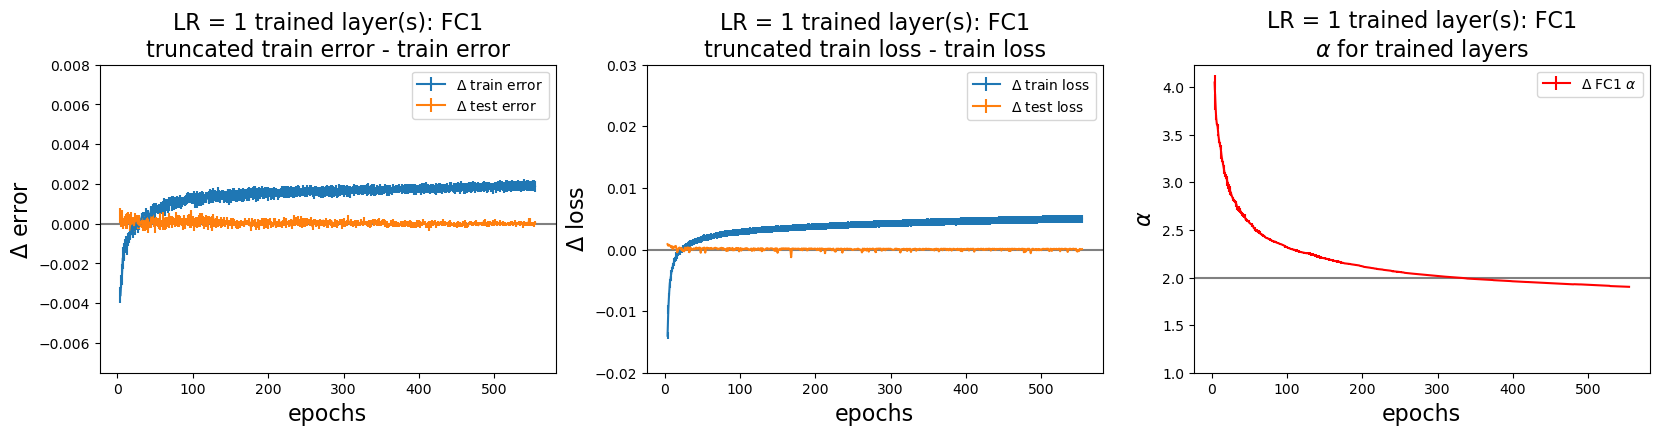

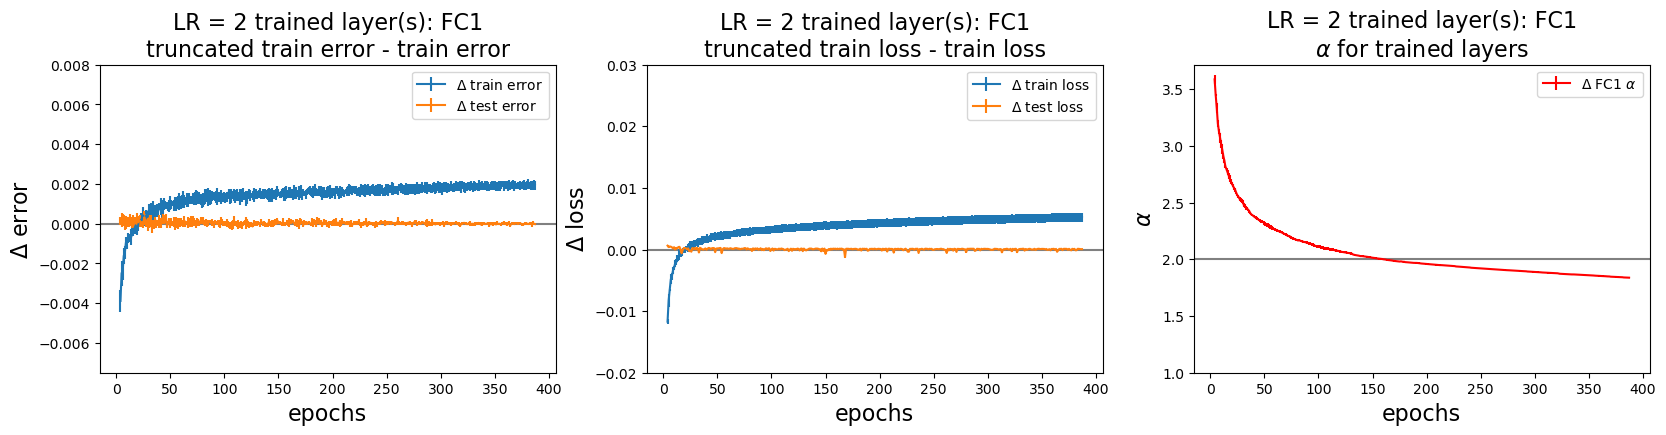

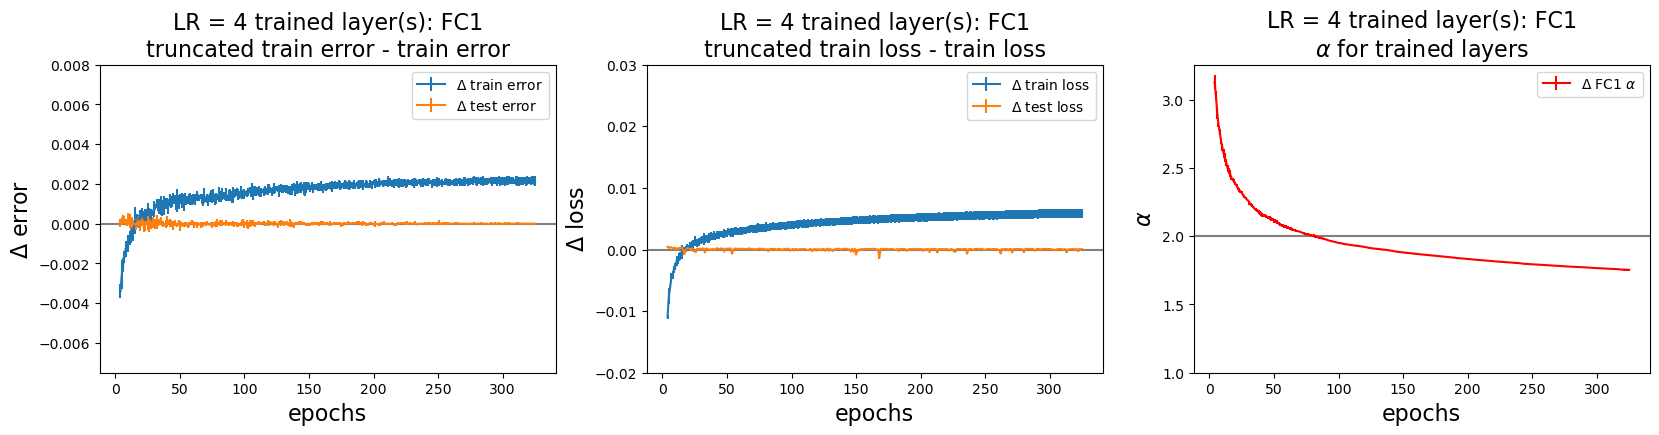

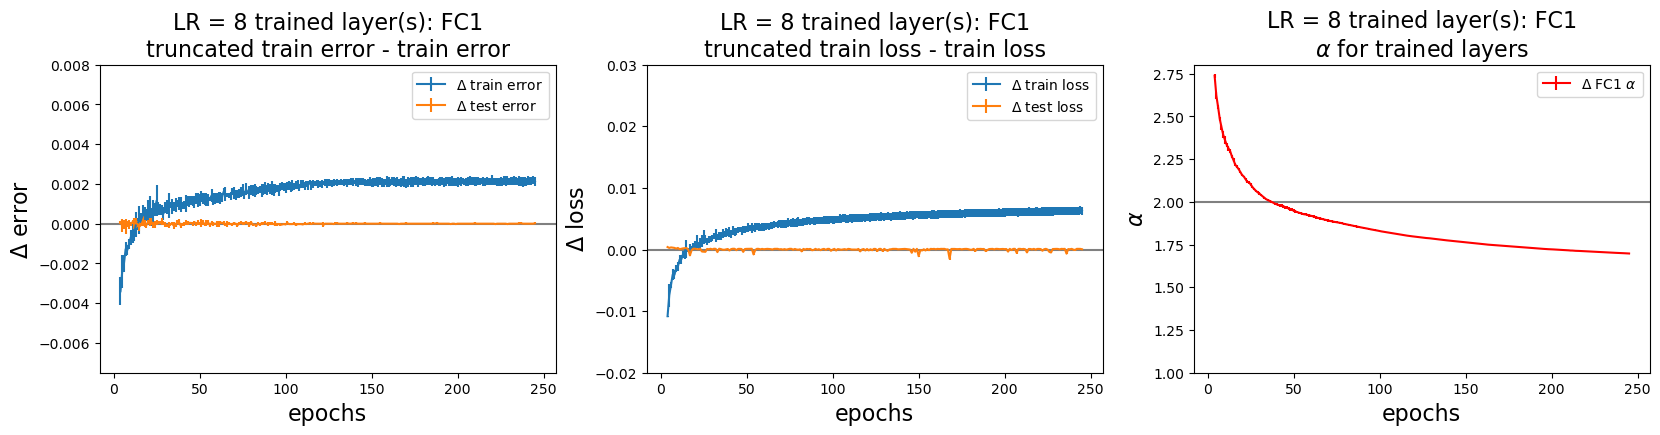

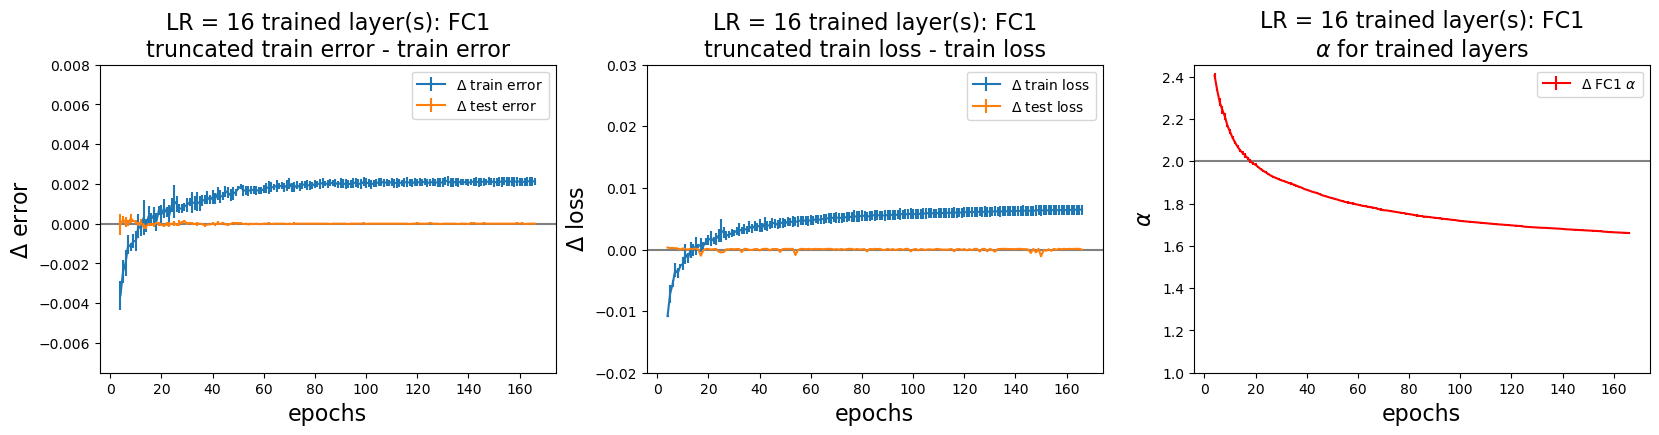

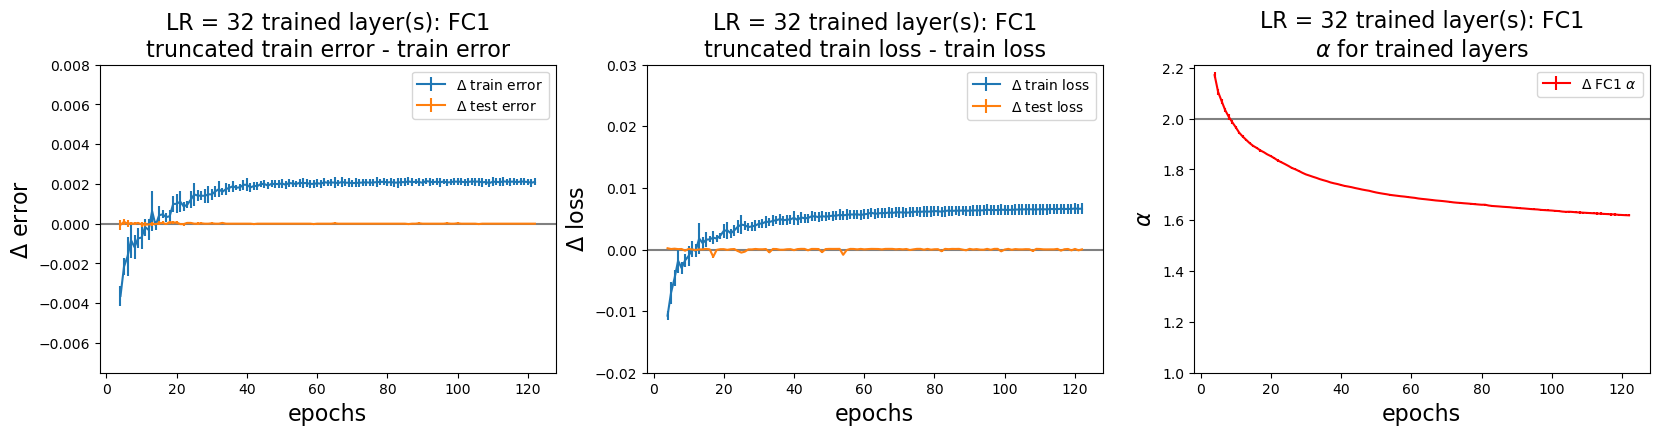

In [5]:
from plot_utils import plot_truncated_accuracy_over_epochs

DS = "MNIST"
search_param = "LR"

for scale in range(6):
  plot_truncated_accuracy_over_epochs(DS, "FC1", search_param, scale, range(5), ylims=(0.008, 0.03), XMIN=False, save_dir="figs/truncated_error")

### Here this we see more or less the same results as for $\lambda_\mbox{PL}$.
The <font color="orange">orange</font> line is always near $0$, the <font color="blue">blue</font> line approcahes an asymptote from below, and the error bars are generally narrow.

Finally, we consider the case where we train only the middle layer, `FC2`, which has $100$ output units. This layer does not produce a single trend when trained over different random seeds, so we have to show each seed separately. This manifests as a sudden balooning of error bars as some of the runs make sudden radical changes in their behaviors. To see it, change the `FC1` argument to `FC2` in either of the two cells above.

Since we are plotting the runs separately, we will now show just the final epoch, and all learning rates (or batch sizes) together. Moreover, in order to make sense of what is happening, we need to show how $\alpha_\mbox{FC2}$ is behaving, which we will show in the third column.

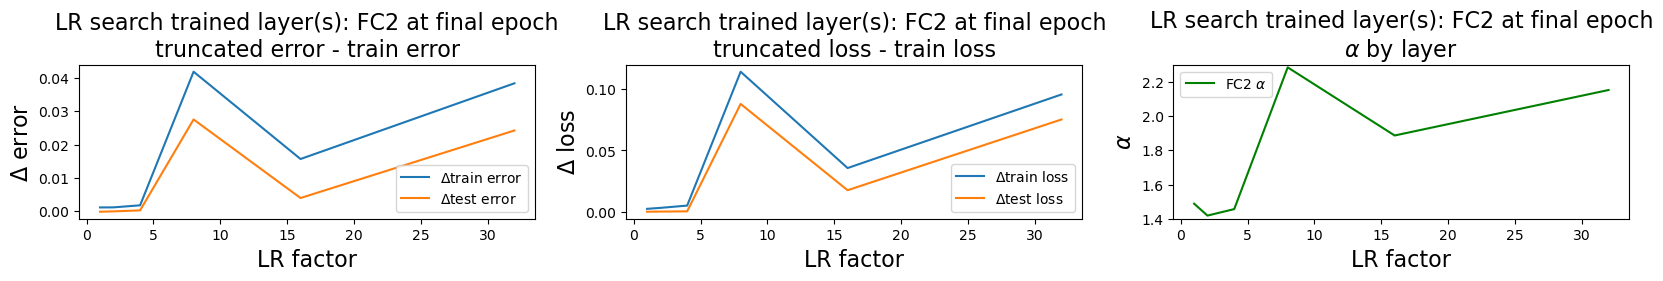

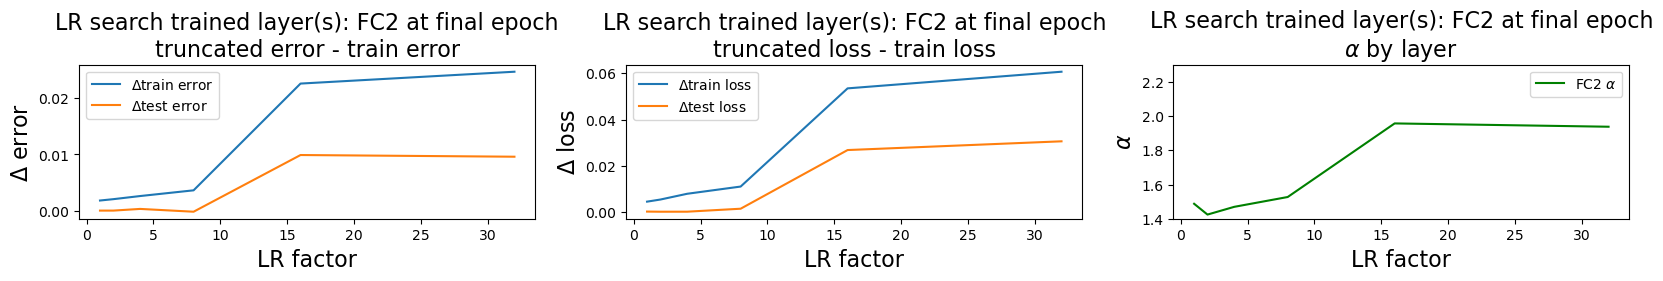

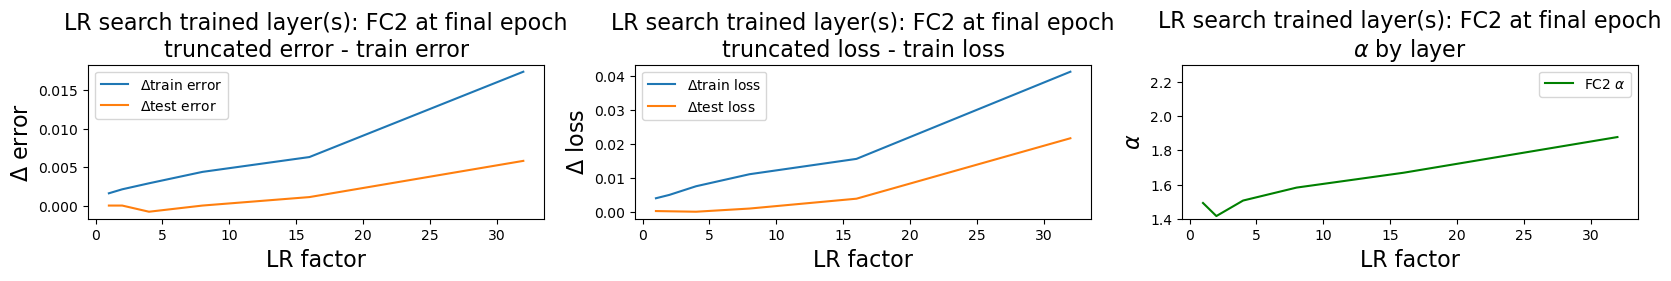

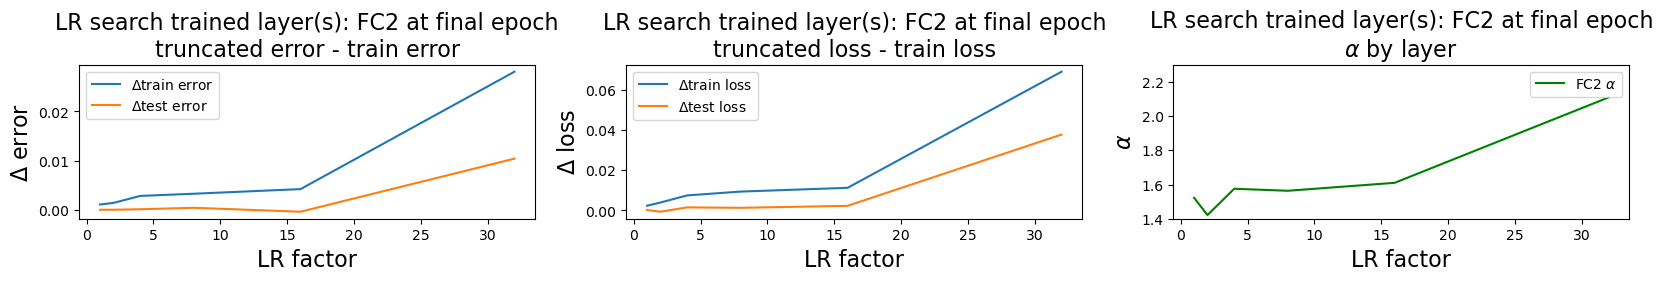

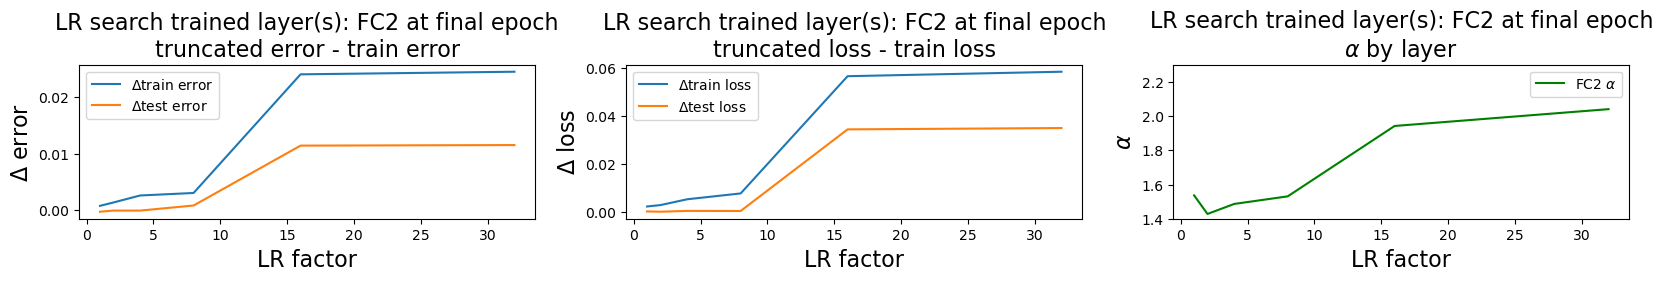

In [6]:
from plot_utils import plot_truncated_errors_by_scales
DS = "MNIST"
search_param = "LR"

for run in range(5):
  plot_truncated_errors_by_scales(DS, "FC2", search_param, range(6), run, XMIN=True, save_dir="figs/truncated_error")

### Notice how different they are from one run to another

Clearly, we can see that although the different runs don't always converge to the same $\alpha$ value, especialy for Learning Rates of $8\times$ or $16\times$ normal, we can nevertheless see that whenever $\alpha_\mbox{FC2}$ is larger, so too are the gaps between error and loss of the truncated and untruncated models, shown in the <font color="orange">orange</font> and <font color="blue">blue</font> lines.

Next, we apply the analysis to the $\lambda_\mbox{detX}$ correlation space, again where only layer FC2 was trained.

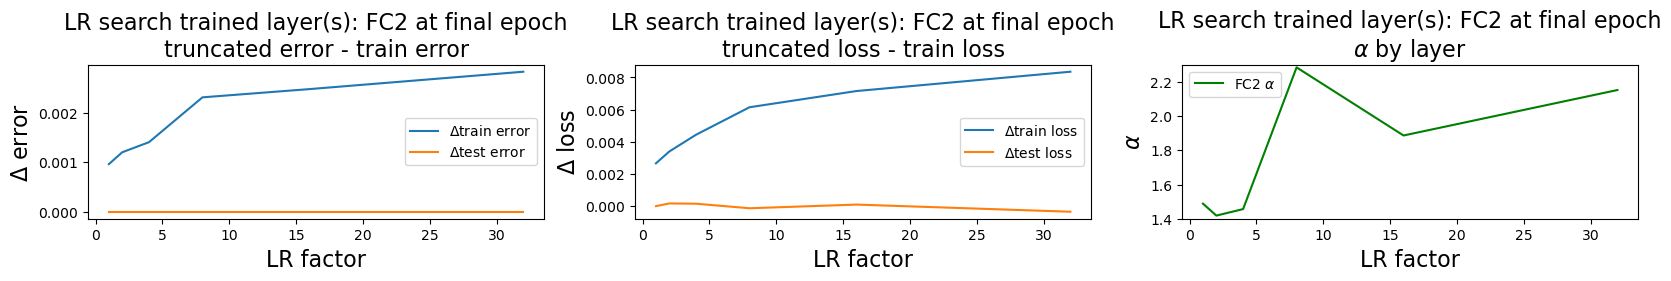

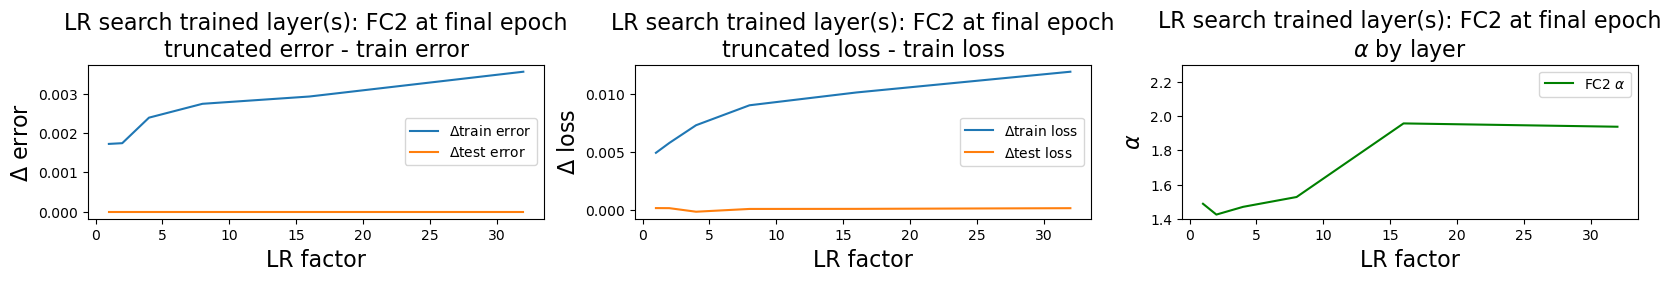

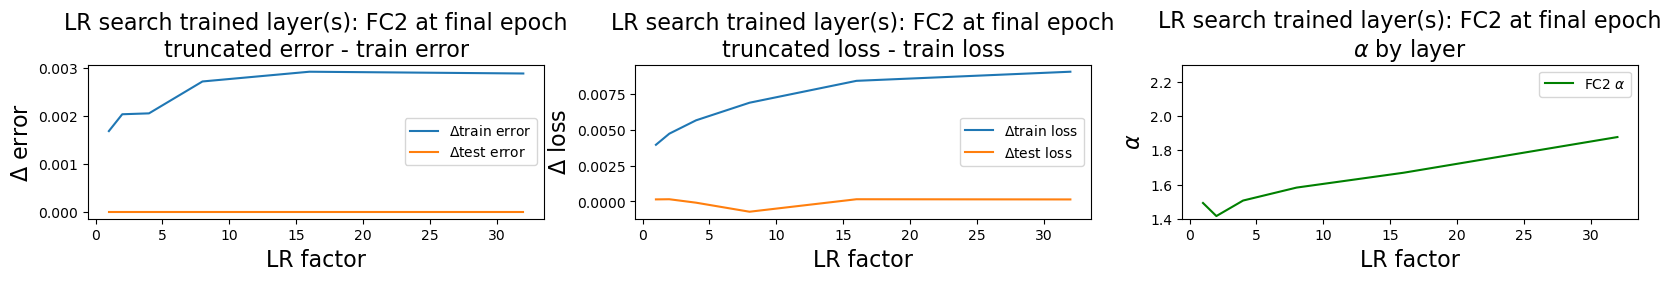

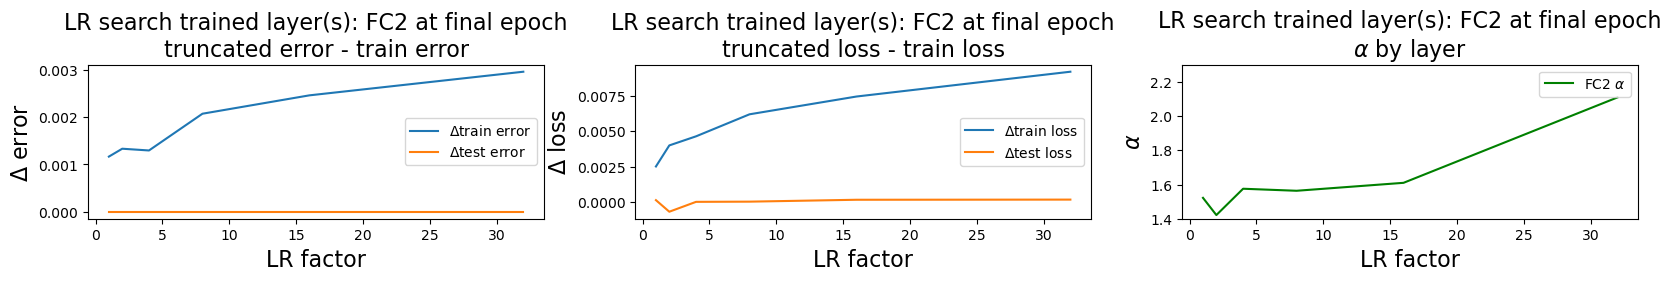

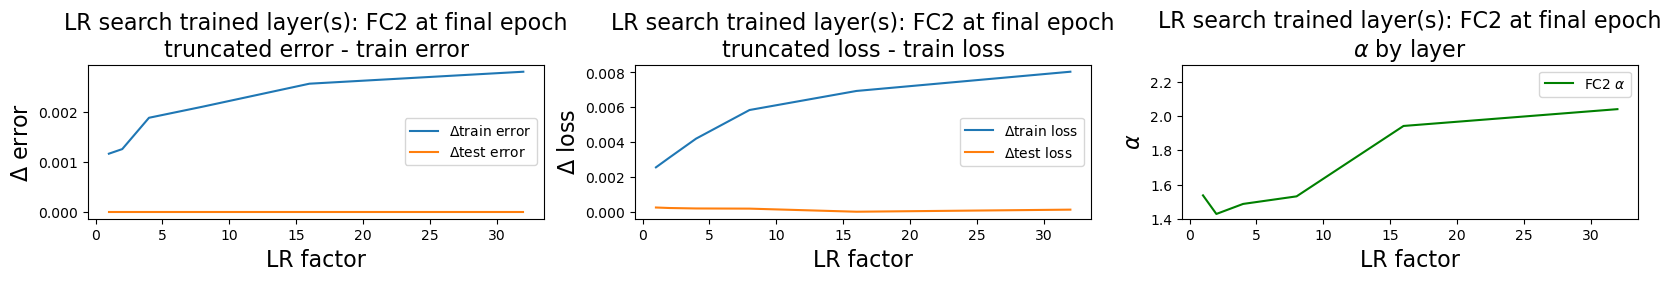

In [7]:
from plot_utils import plot_truncated_errors_by_scales

DS = "MNIST"
search_param = "LR"

for run in range(5):
  plot_truncated_errors_by_scales(DS, "FC2", search_param, range(6), run, XMIN=False, save_dir="figs/truncated_error")

### In this case, the similarity is somewhat weaker. 
Above, we were comparing $\alpha$ with the Effective Correlation Space based on $\lambda_\mbox{PL}$, which is used to compute $\alpha$. Recall that $\alpha$ is computed by fitting a power law distribution (Pareto) to the eigenvalues larger than $\lambda_\mbox{PL}$. Here, we are using a different Effective Correlation Space, based on $\lambda_\mbox{detX}$ which is chosen such that the product of eigenvalues $\lambda > \lambda_\mbox{PL}$ is close to $1$. Given that's the case, we would not necessarily expect $\alpha$ to reflect a close relationship with the truncated model's error gaps, but there is still a general trend that as $\alpha$ is less, the truncated *training* error gap is less. (The truncated test error gap is almost always close to $0$, and so there is little meaningful variation to compare.)


The trends shown above establish that there is a relation between $\alpha$ and the error gap between truncated and un-truncated models, which suggests that $\alpha$ is a measure of *model regularization*. That is, generally, the lower $\alpha$ is, the more evidence that the model's predictions are produced by the Effective Correlation Space, and that any overfitting is due to its complement, i.e. the Bulk. Above we see this independently for several random seeds and learning rates, but if we pool all of those experiments, we can see how $\alpha$ and the error gap interact overall.

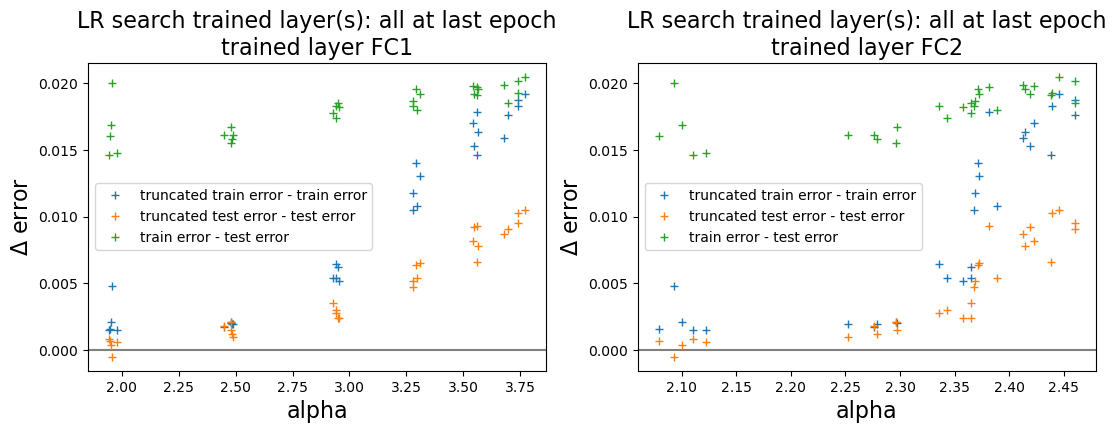

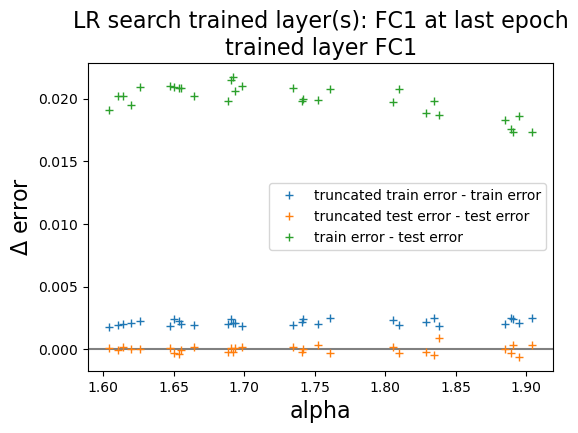

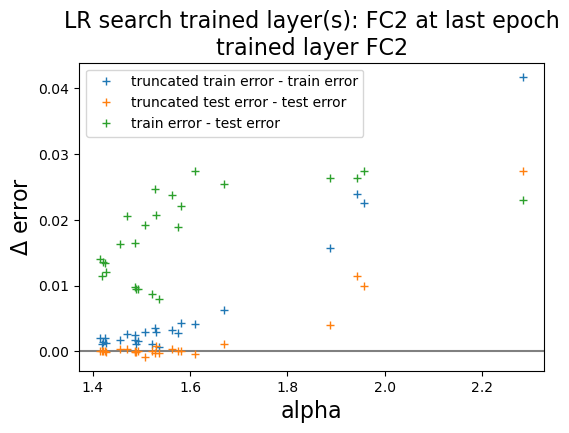

In [8]:
from plot_utils import plot_truncated_errors_by_metric

DS = "MNIST"
search_param = "LR"
XMIN=True

plot_truncated_errors_by_metric(DS, "all", search_param, range(6), range(5), [0, 1], "alpha", XMIN=XMIN, save_dir="figs/truncated_error")
plot_truncated_errors_by_metric(DS, "FC1", search_param, range(6), range(5), [0   ], "alpha", XMIN=XMIN, save_dir="figs/truncated_error")
plot_truncated_errors_by_metric(DS, "FC2", search_param, range(5), range(5), [   1], "alpha", XMIN=XMIN, save_dir="figs/truncated_error")

### Here, the effect depends on which layers were trained in the model.

In the first case, where all layers are trained, the error gap visibly decreases as a function of $\alpha$, in both layers. Less drastically, but5 still consistently, the gap between (untruncated) train and test accuracy also declines. As in the Model Quality experiment, (See notebook `WW_MLP3_Analysis_Model_Quality.ipynb`,) once the FC1 layer $\alpha$ goes below $2.0$, the relationship with train-test error gap begins to break down.

In the second case, the relationship is less clear. *All* of the $\alpha$ metrics are below $2.0$, and there is little visible variation in the truncated error gap for train or test data. From $\alpha$ in the range of $1.9$ down to $1.8$ there appears to be a very slight *upward* trend in the generalization gap between train and test errors, but it is more or less constant below that point. 

In the third case, once again, the truncated error gap decreases with $\alpha$ all the way down to $1.4$, and the generalization gap between train and test errors seems to decrease when $\alpha$ is less than $1.8$. 

The notion of **Ideal Learning** is that when *all* of the conditions are met, i.e. $\alpha$ is low, but not less than $2.0$, that $\lambda_\mbox{PL} \simeq \lambda_\mbox{detX}$, and that the truncated test error is low, then the model can be said to have undergone Ideal Learning, in a Statistical Mechanic sense of having reached a high quality equilibrium.

Recall that the $\hat{\alpha}$ metric is intended to counteract some of the distortions that can occue when $\alpha < 2$. Below we show the same comparison as above, except that we replace $\alpha$ with $\hat{\alpha}$ in layers where $\alpha$ is generally under $2.0$.

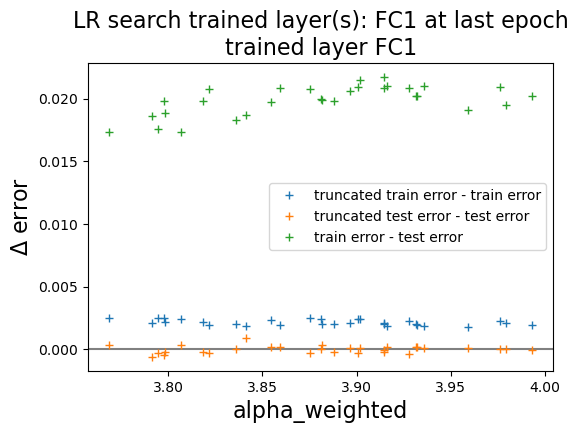

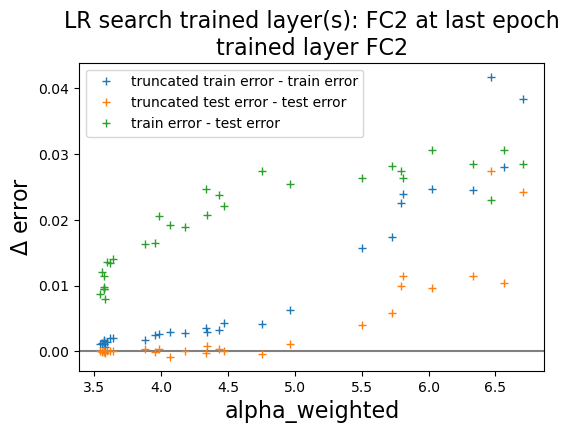

In [9]:
from plot_utils import plot_truncated_errors_by_metric

DS = "MNIST"
search_param = "LR"
XMIN=True

plot_truncated_errors_by_metric(DS, "FC1", search_param, range(6), range(5), [0], "alpha_weighted", XMIN=XMIN, save_dir="figs/truncated_error")
plot_truncated_errors_by_metric(DS, "FC2", search_param, range(6), range(5), [1], "alpha_weighted", XMIN=XMIN, save_dir="figs/truncated_error")

### This time, we can see that in FC1, there is now a slight downward trend in generalization gap as $\hat{\alpha}$ decreases.

We can also see that in the FC2 layer the relationship is preserved, and is slightly more linear in appearance due to having a few large values pulled closer to the rest.